In [123]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder

In [163]:
df = pd.read_csv("../data/Rumah.comdataset_v3.csv")
df = df.drop(columns=['Property Link', 'ID'])
df['Listing Area'] = df['Listing Area'].str.replace(' m²', '')
df = df.astype({'Listing Area':'int64'})
#Print the shape of the dataset before removing outliers
print(df.shape)

(19439, 7)


In [164]:
df.head()

,Price,Street Address,Bed,Bath,Listing Area,Certificate,Jakarta Division
0,2.960000e+09,Cempaka Putih,4,3,92,SHM - Sertifikat Hak Milik,CENTRAL
1,4.400000e+08,Salemba,2,2,40,SHM - Sertifikat Hak Milik,CENTRAL
2,2.900000e+09,Cempaka Putih,4,3,92,SHM - Sertifikat Hak Milik,CENTRAL
3,1.061321e+09,Cempaka Putih,2,2,58,SHM - Sertifikat Hak Milik,CENTRAL
4,1.061000e+09,Cempaka Putih,2,2,58,SHM - Sertifikat Hak Milik,CENTRAL


In [165]:
y = df.Price
X = df.drop(['Price'], axis=1)

In [166]:
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, 
                                                            train_size=0.8, test_size=0.2)

In [167]:
X_concat = pd.concat([X_train_full, y_train], axis=1)
X_concat.shape

(15551, 7)

In [168]:
#Before we start, perform outlier detection and removal (removing all rows with outlier values) for numerical columns
outliers = pd.DataFrame()


numerical_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]
#Keep removing outliers until there are no more outliers (run the loop 5 times)
for i in range(10):
    #Check if there are any outliers
    for col in numerical_cols:
        # Perform outlier detection using Interquartile Range
        Q1 = X_concat[col].quantile(0.05)
        Q3 = X_concat[col].quantile(0.95)
        IQR = Q3 - Q1
#         # Before removing outliers, put the outliers in a separate dataframe
#         outliers = outliers.append(df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)])
        # Remove outliers
        X_concat = X_concat[(X_concat[col] >= Q1 - 1.5*IQR) & (X_concat[col] <= Q3 + 1.5*IQR)]



#Print the shape of the dataset after outlier removal
print(X_concat.shape)

(15204, 7)


In [169]:
y_train = X_concat.Price
X_train_full = X_concat.drop(['Price'], axis=1)

In [170]:
# cols_with_missing = [col for col in X_train_full.columns if X_train_full[col].isnull().any()] 
# X_train_full.drop(cols_with_missing, axis=1, inplace=True)
# X_valid_full.drop(cols_with_missing, axis=1, inplace=True)

In [171]:
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]
high_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() >= 10 and 
                        X_train_full[cname].dtype == "object"]
low_cardinality_cols, high_cardinality_cols

(['Jakarta Division'], ['Street Address', 'Certificate'])

In [172]:
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

In [173]:
numerical_cols

['Bed', 'Bath', 'Listing Area']

In [174]:
my_cols = low_cardinality_cols + high_cardinality_cols+ numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [175]:
# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Jakarta Division', 'Street Address', 'Certificate']


In [176]:
# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, preds)
    r2 = r2_score(y_valid, preds)
    #Get the number of samples and features in the validation set
    n_samples, n_features = X_train.shape
    #Calculate the degree of freedoms for residuals
    dof_residuals = n_samples - n_features - 1
    #Calculate the adjusted r2 score
    adj_r2 = 1 - (1 - r2) * (dof_residuals / (n_samples - 1))
    #calculate the root mean squared error
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    mape = mean_absolute_percentage_error(preds, y_valid)
    return mae, rmse, adj_r2, mape, preds


In [177]:
# Function to optimize hyperparameters for Random Forest
#Return the parameters that give the best MAE
def optimize_rf(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(random_state=0)
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    max_features = [1.0, 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
                     'max_features': max_features,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf,
                        'bootstrap': bootstrap}
    #The target metric is MAE
    scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring=scorer)
    rf_random.fit(X_train, y_train)
    preds = rf_random.predict(X_valid)
    mae = mean_absolute_error(y_valid, preds)
    r2 = r2_score(y_valid, preds)
    #Get the number of samples and features in the validation set
    n_samples, n_features = X_train.shape
    #Calculate the degree of freedoms for residuals
    dof_residuals = n_samples - n_features - 1
    #Calculate the adjusted r2 score
    adj_r2 = 1 - (1 - r2) * (dof_residuals / (n_samples - 1))
    #calculate the root mean squared error
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    return mae, rmse, adj_r2, rf_random.best_params_

In [178]:
# Using approach 1: Drop Categorical Variables
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_valid.select_dtypes(exclude=['object'])

print("MAE, RMSE, Adjusted R2, MPAE from Approach 1 (Drop categorical variables):")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_valid))

MAE, RMSE, Adjusted R2, MPAE from Approach 1 (Drop categorical variables):
(4826718006.909149, 20800853535.8639, 0.1724684639028441, 0.7432703909588562, array([1.80103861e+09, 4.83270283e+09, 1.37064232e+10, ...,
       1.04609408e+09, 6.01669864e+09, 1.79165793e+09]))


In [179]:
from sklearn.preprocessing import OrdinalEncoder

# Make copy to avoid changing original data 
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
label_X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
label_X_valid[object_cols] = ordinal_encoder.transform(X_valid[object_cols])

print("MAE, R2, Adjusted R2, MPAE from Approach 2 (Ordinal Encoding):") 
a = score_dataset(label_X_train, label_X_valid, y_train, y_valid)
print(a)

MAE, R2, Adjusted R2, MPAE from Approach 2 (Ordinal Encoding):
(3581141421.3761463, 19479107457.181393, 0.27443784274397065, 0.6115844143483223, array([1.83869575e+09, 5.13184286e+09, 7.93890000e+09, ...,
       9.67486456e+08, 6.29668333e+09, 1.79791883e+09]))


In [180]:
y_valid = y_valid/100000000
pred = pd.Series(a[-1])/100000000
pred.name = "Price_prediction"
total_df = pd.concat([X_valid, y_valid], axis=1)
total_df.reset_index(inplace=True)
total_df = pd.concat([total_df, pred], axis=1)
total_df.drop('index', axis=1, inplace=True)
total_df

,Jakarta Division,Street Address,Certificate,Bed,Bath,Listing Area,Price,Price_prediction
0,WEST,Kali Deres,SHM - Sertifikat Hak Milik,3,2,115,18.00,18.386958
1,WEST,Kebon Jeruk,SHM - Sertifikat Hak Milik,4,5,250,43.00,51.318429
2,CENTRAL,Sawah Besar,SHM - Sertifikat Hak Milik,10,10,498,63.00,79.389000
3,WEST,Jelambar,SHM - Sertifikat Hak Milik,3,3,150,21.00,25.296470
4,CENTRAL,Cempaka Putih,SHM - Sertifikat Hak Milik,7,6,800,250.00,94.443899
...,...,...,...,...,...,...,...,...
3883,WEST,Joglo,SHM - Sertifikat Hak Milik,2,2,160,49.00,23.116000
3884,NORTH,Pantai Indah Kapuk,PPJB - Perjanjian Pengikatan Jual Beli,5,4,274,80.00,102.826000
3885,EAST,Jatinegara,SHM - Sertifikat Hak Milik,3,3,68,10.00,9.674865
3886,SOUTH,Ampera,SHM - Sertifikat Hak Milik,5,4,261,75.00,62.966833


In [181]:
error = abs((total_df.Price - total_df.Price_prediction)) / total_df.Price * 100
error.name = "Prediction_Error"
total_df = pd.concat([total_df, error], axis=1)
total_df

,Jakarta Division,Street Address,Certificate,Bed,Bath,Listing Area,Price,Price_prediction,Prediction_Error
0,WEST,Kali Deres,SHM - Sertifikat Hak Milik,3,2,115,18.00,18.386958,2.149764
1,WEST,Kebon Jeruk,SHM - Sertifikat Hak Milik,4,5,250,43.00,51.318429,19.345183
2,CENTRAL,Sawah Besar,SHM - Sertifikat Hak Milik,10,10,498,63.00,79.389000,26.014286
3,WEST,Jelambar,SHM - Sertifikat Hak Milik,3,3,150,21.00,25.296470,20.459382
4,CENTRAL,Cempaka Putih,SHM - Sertifikat Hak Milik,7,6,800,250.00,94.443899,62.222440
...,...,...,...,...,...,...,...,...,...
3883,WEST,Joglo,SHM - Sertifikat Hak Milik,2,2,160,49.00,23.116000,52.824490
3884,NORTH,Pantai Indah Kapuk,PPJB - Perjanjian Pengikatan Jual Beli,5,4,274,80.00,102.826000,28.532500
3885,EAST,Jatinegara,SHM - Sertifikat Hak Milik,3,3,68,10.00,9.674865,3.251354
3886,SOUTH,Ampera,SHM - Sertifikat Hak Milik,5,4,261,75.00,62.966833,16.044222


In [185]:
max(error)

102483448900.86581

In [47]:
#Using Ordinal Encoding with Hyperparameter Optimization
print("MAE, R2, Adjusted R2 from Approach 2 (Ordinal Encoding) with Hyperparameter Optimization:")
print(optimize_rf(label_X_train, label_X_valid, y_train, y_valid))

MAE, R2, Adjusted R2 from Approach 2 (Ordinal Encoding) with Hyperparameter Optimization:
Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

In [100]:
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

#To remove warnings
OH_cols_train.columns = OH_cols_train.columns.astype('str')
OH_cols_valid.columns = OH_cols_valid.columns.astype('str')

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

print("MAE, MAPE from Approach 3 (One-Hot Encoding):") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

MAE, MAPE from Approach 3 (One-Hot Encoding):
(3688058261.3116755, 15091263303.377794, 0.403928057756222, 0.3650598820061322)


In [ ]:
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]
high_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() >= 10 and 
                        X_train_full[cname].dtype == "object"]
low_cardinality_cols, high_cardinality_cols

In [ ]:
# Make copy to avoid changing original data 
mix_X_train = X_train.copy()
mix_X_valid = X_valid.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
mix_X_train[high_cardinality_cols] = ordinal_encoder.fit_transform(X_train[high_cardinality_cols])
mix_X_valid[high_cardinality_cols] = ordinal_encoder.transform(X_valid[high_cardinality_cols])

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(mix_X_train[low_cardinality_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(mix_X_valid[low_cardinality_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = mix_X_train.drop(low_cardinality_cols, axis=1)
num_X_valid = mix_X_valid.drop(low_cardinality_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

# print("MAE from Approach 4 (Ordinal Encoding + One-Hot Encoding):") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

In [ ]:
y_valid.mean()

In [ ]:
# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, preds)
    r2 = r2_score(y_valid, preds)
    #Get the number of samples and features in the validation set
    n_samples, n_features = X_train.shape
    #Calculate the degree of freedoms for residuals
    dof_residuals = n_samples - n_features - 1
    #Calculate the adjusted r2 score
    adj_r2 = 1 - (1 - r2) * (dof_residuals / (n_samples - 1))
    return mae, r2, adj_r2

In [ ]:
#Make a dataframe whose columns are before and after encoding
encoder_explanation = pd.DataFrame(columns=['before encoding', 'after encoding'])

#Print the lists for each categorical variable (before and after encoding)
#Put them in three separate columns in a dataframe for easy comparison
#The columns are: before encoding, after encoding
#The rows are categorical variable + value (as "before encoding") and the corresponding encoded value (as "after encoding")
for col in object_cols:
    for i in range(len(X_train[col].unique())):
        encoder_explanation.loc[col + ' ' + str(X_train[col].unique()[i])] = [X_train[col].unique()[i], label_X_train[col].unique()[i]]
        encoder_explanation.loc[col + ' ' + str(X_train[col].unique()[i]), 'before encoding'] = X_train[col].unique()[i]
        encoder_explanation.loc[col + ' ' + str(X_train[col].unique()[i]), 'after encoding'] = label_X_train[col].unique()[i]

encoder_explanation

#Save the encoder_explanation dataframe to a csv file
encoder_explanation.to_csv('ordinal_encoder_explanation.csv')


In [ ]:
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]
high_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() >= 10 and 
                        X_train_full[cname].dtype == "object"]
low_cardinality_cols, high_cardinality_cols

(['Jakarta Division'], ['Street Address', 'Certificate'])

/var/folders/p4/hlsdgszd7ysfnhxp8_f64bhm0000gn/T/ipykernel_71040/346260603.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt='.1g')


<Axes: >

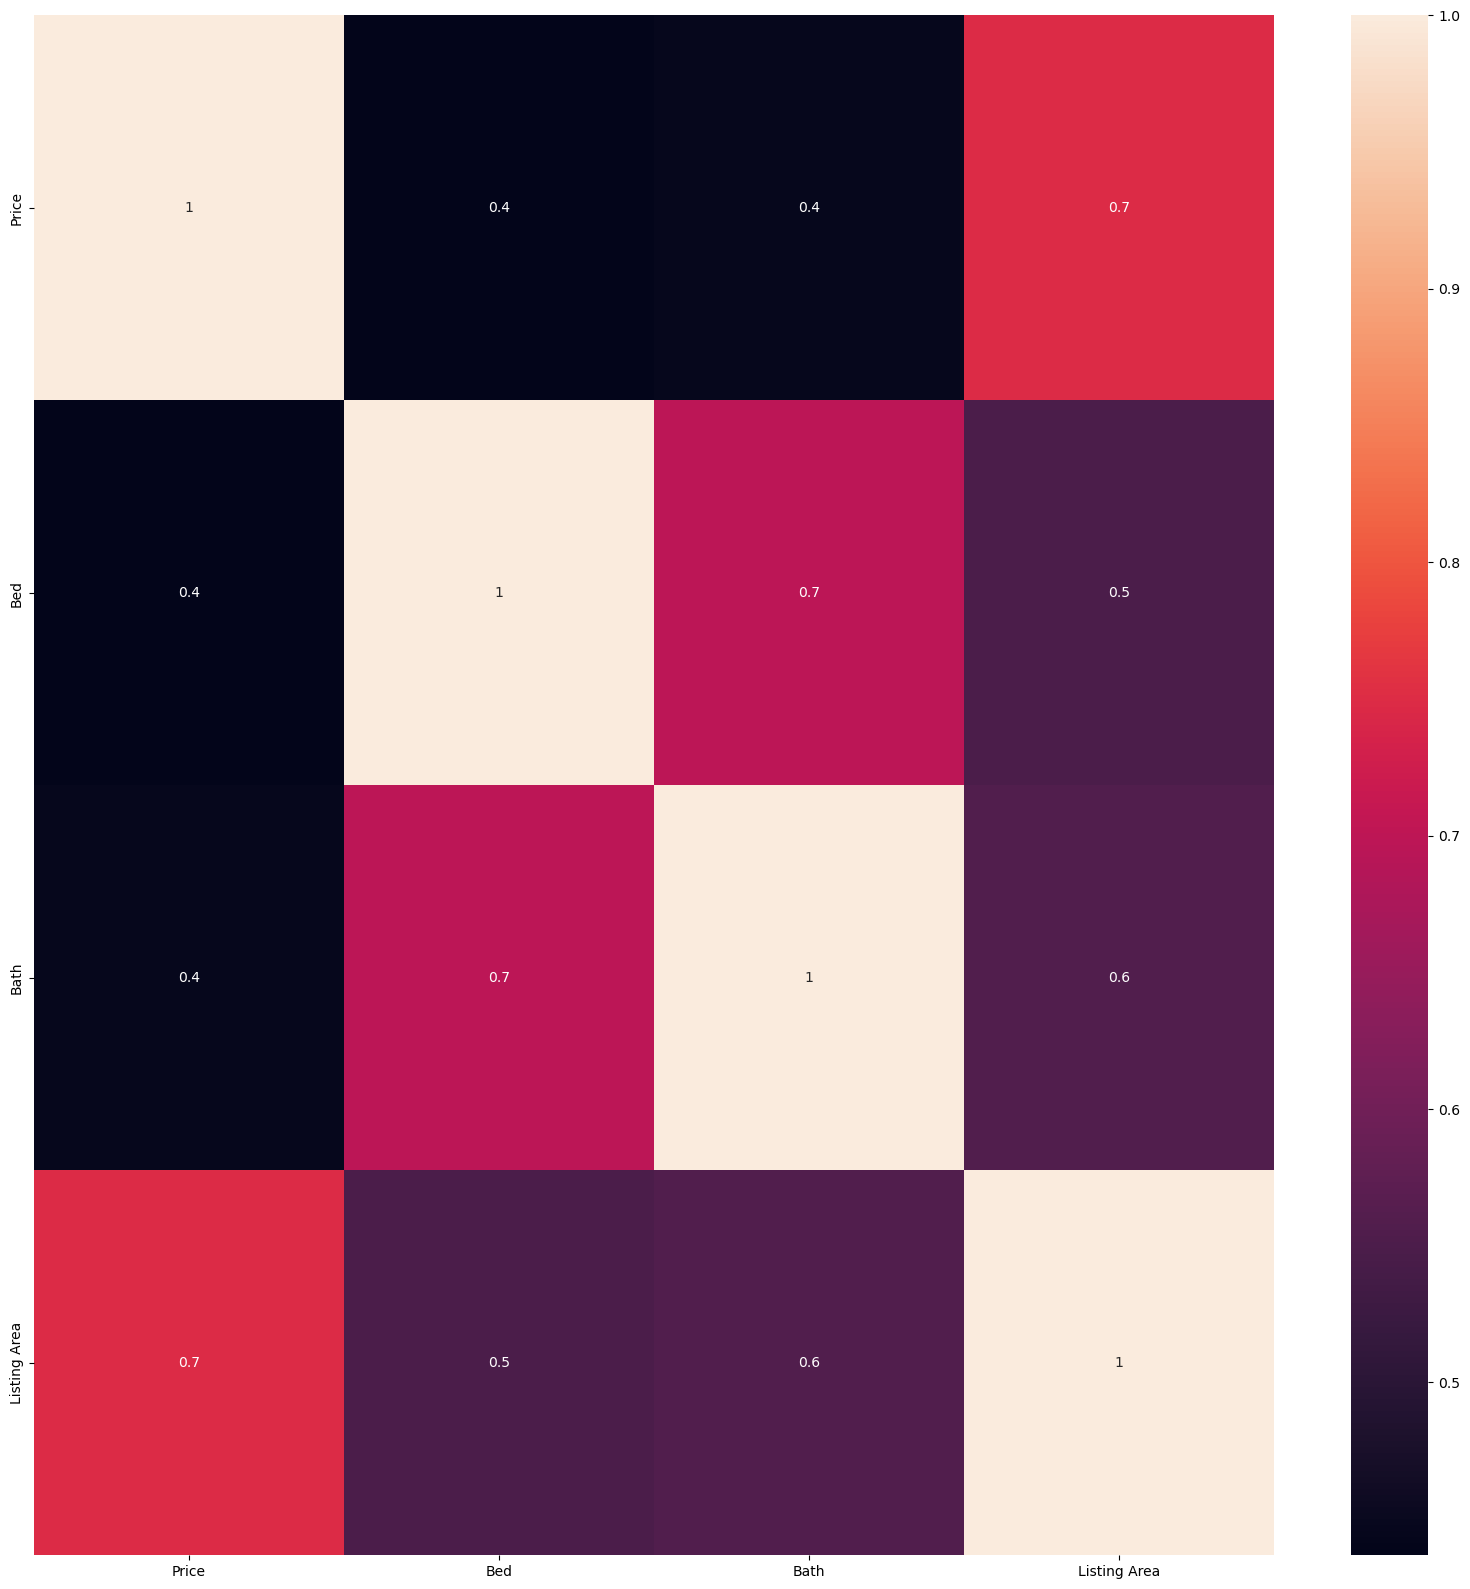

In [ ]:
#Try to visualize the data to see if there is any correlation between the features and the target
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True, fmt='.1g')


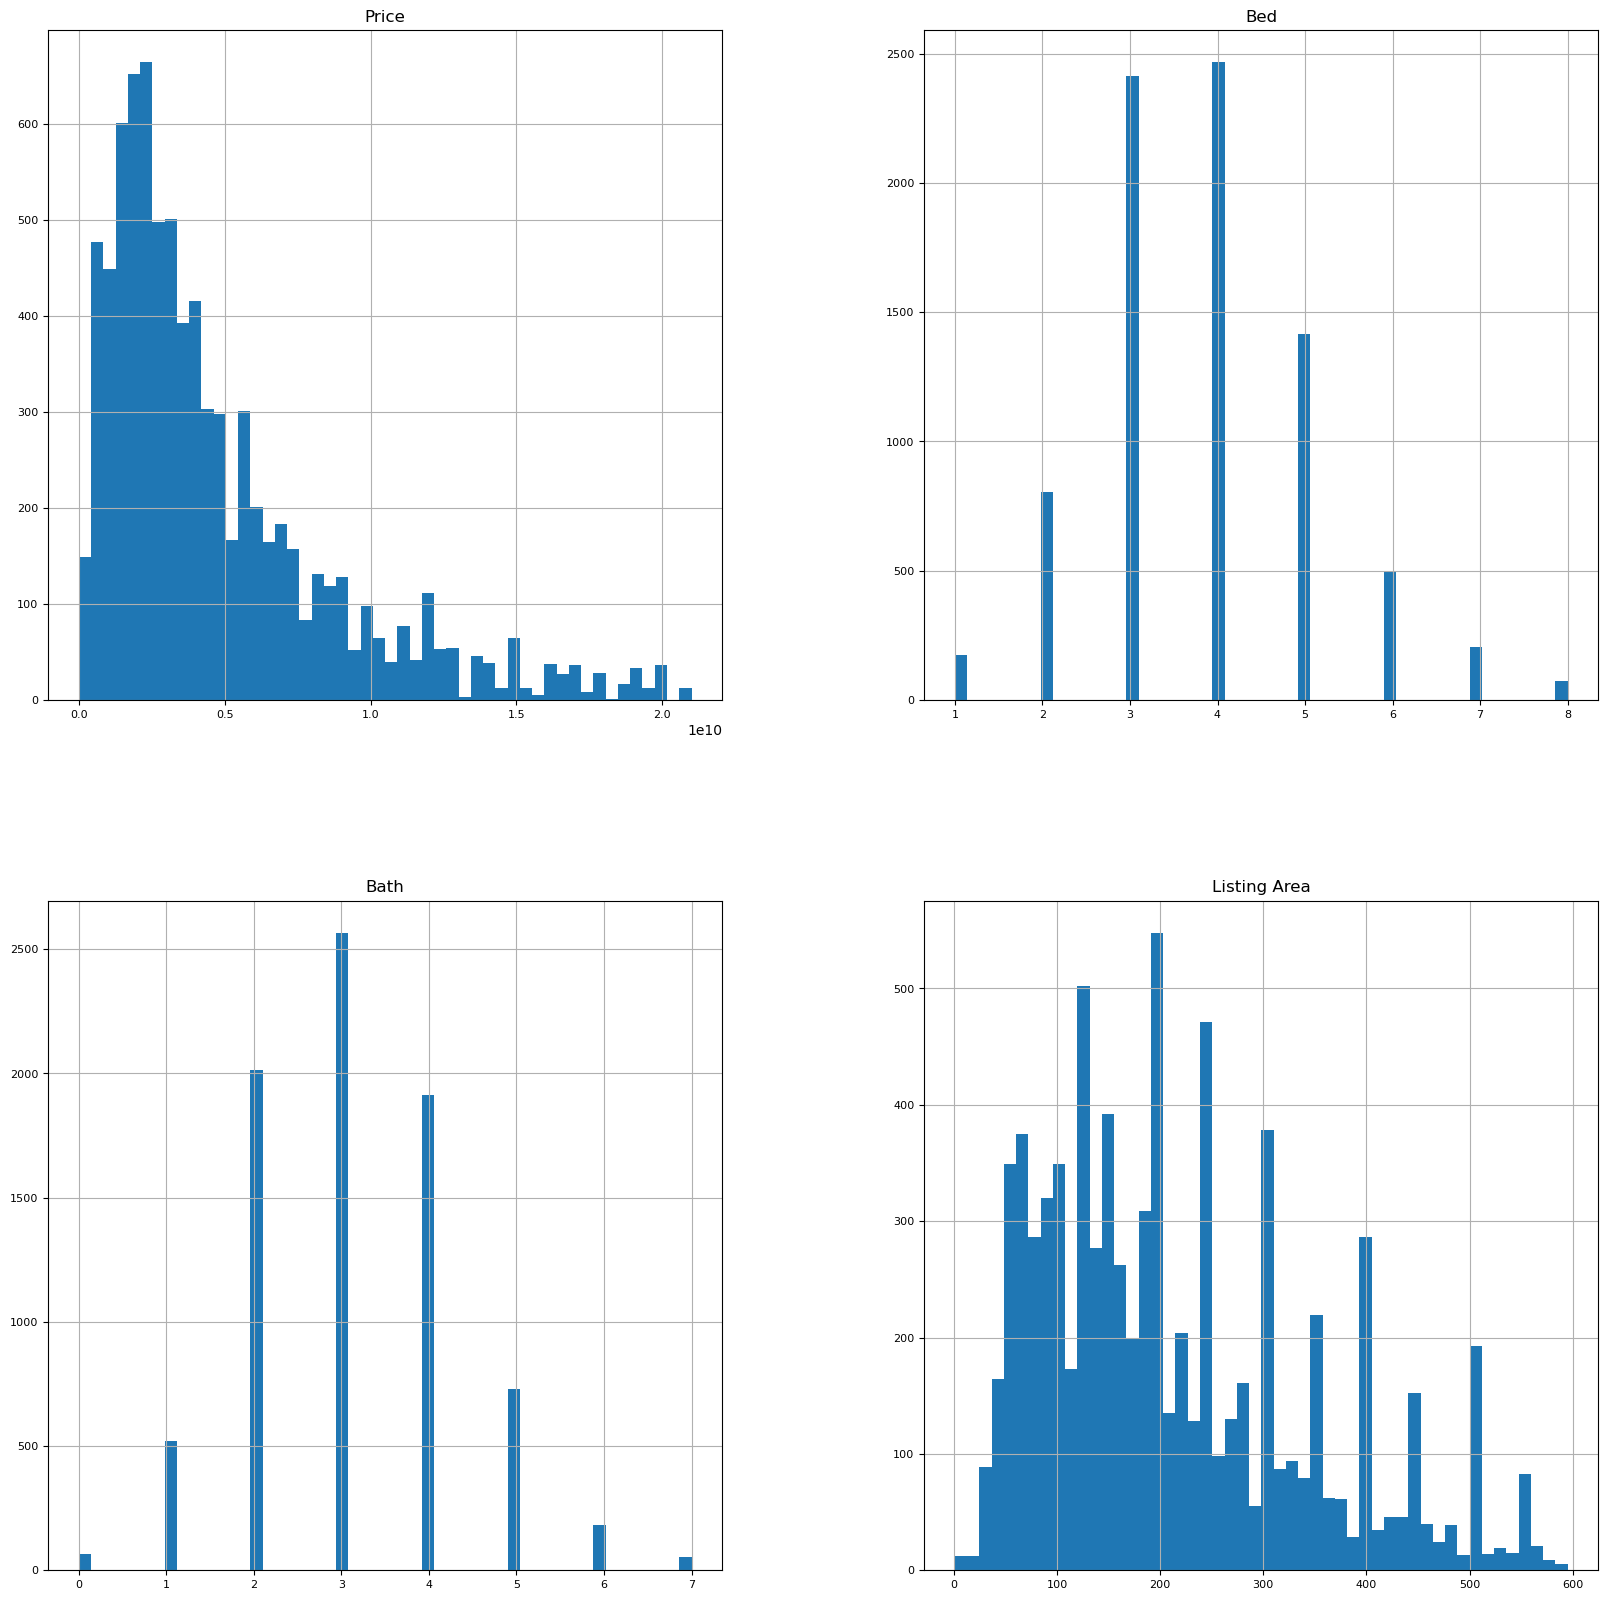

In [ ]:
#Check the histograms of all the features
df.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations


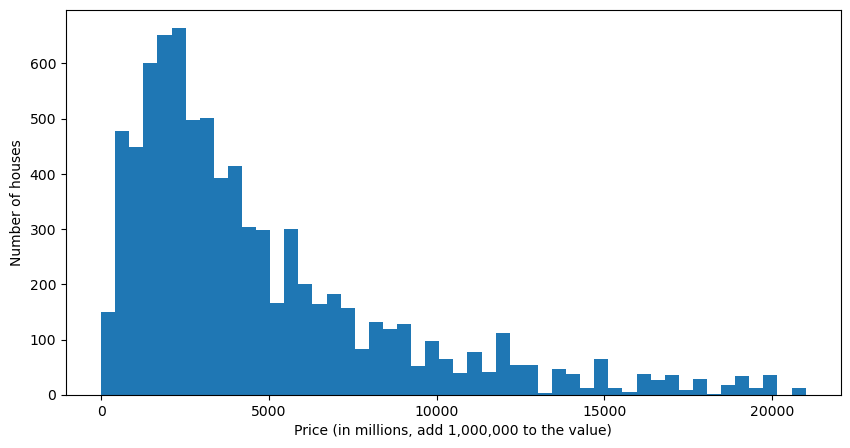

In [ ]:
#Specifically make a histogram only for price, but this time write the full scale of the x value (in millions)
plt.figure(figsize=(10, 5))
#Divide the price by 1,000,000 and add the text "M" to the x label
plt.hist(df['Price']/1000000, bins=50)
plt.xlabel('Price (in millions, add 1,000,000 to the value)')
plt.ylabel('Number of houses')
plt.show()

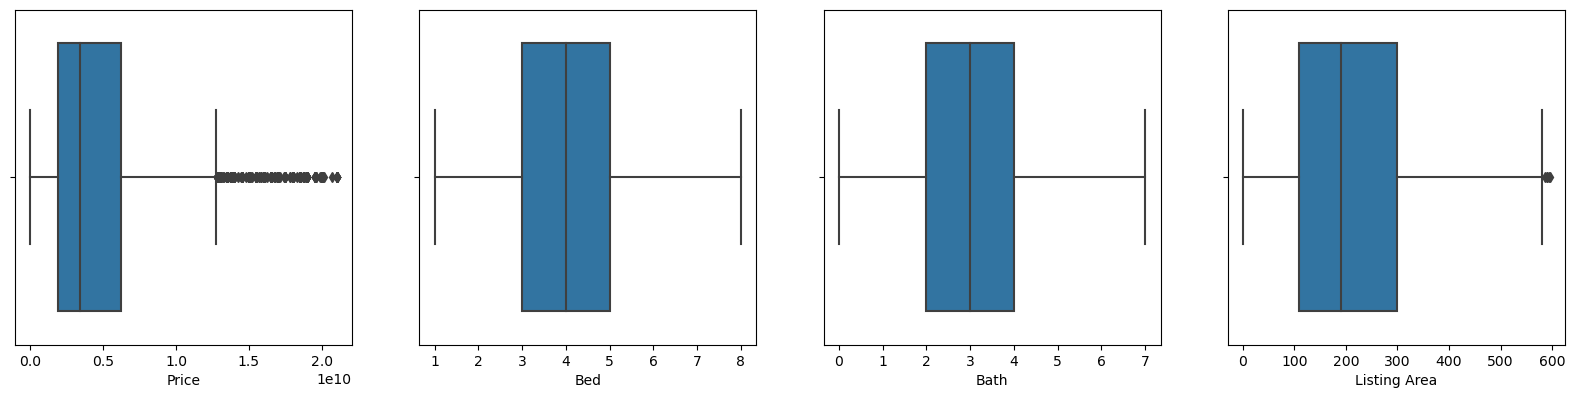

In [ ]:
#Perform outlier detection by plotting boxplots for the numerical features
plt.figure(figsize=(20, 20))
#Get all columns with numerical data from df
numerical_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]
#Plot boxplots for all numerical columns
for i in range(len(numerical_cols)):
    plt.subplot(4, 4, i+1)
    sns.boxplot(x=df[numerical_cols[i]])


In [ ]:
#Print the top 10 rows with the highest price
df.sort_values(by=['Price'], ascending=False).head(50)

,Price,Street Address,Bed,Bath,Listing Area,Certificate,Jakarta Division
5297,21000000000,Pondok Indah,5,5,545,SHM - Sertifikat Hak Milik,SOUTH
5312,21000000000,Pondok Indah,5,4,500,SHM - Sertifikat Hak Milik,SOUTH
9609,21000000000,Pluit,2,2,350,SHM - Sertifikat Hak Milik,NORTH
934,21000000000,Menteng,4,4,370,SHM - Sertifikat Hak Milik,CENTRAL
5747,21000000000,Kebayoran Baru,7,4,500,SHM - Sertifikat Hak Milik,SOUTH
4967,21000000000,Cipete,7,5,360,SHM - Sertifikat Hak Milik,SOUTH
5547,21000000000,Kebayoran Lama,2,3,236,SHM - Sertifikat Hak Milik,SOUTH
8662,21000000000,Pantai Indah Kapuk,4,4,446,SHGB - Hak Guna Bangunan,NORTH
9592,21000000000,Pantai Indah Kapuk,7,7,486,SHM - Sertifikat Hak Milik,NORTH
5352,21000000000,Panglima Polim,7,7,386,SHM - Sertifikat Hak Milik,SOUTH


In [ ]:
#Print the top 10 rows with the highest price
df.sort_values(by=['Price'], ascending=False).head(50)

,Price,Street Address,Bed,Bath,Listing Area,Certificate,Jakarta Division
5297,21000000000,Pondok Indah,5,5,545,SHM - Sertifikat Hak Milik,SOUTH
5312,21000000000,Pondok Indah,5,4,500,SHM - Sertifikat Hak Milik,SOUTH
9609,21000000000,Pluit,2,2,350,SHM - Sertifikat Hak Milik,NORTH
934,21000000000,Menteng,4,4,370,SHM - Sertifikat Hak Milik,CENTRAL
5747,21000000000,Kebayoran Baru,7,4,500,SHM - Sertifikat Hak Milik,SOUTH
4967,21000000000,Cipete,7,5,360,SHM - Sertifikat Hak Milik,SOUTH
5547,21000000000,Kebayoran Lama,2,3,236,SHM - Sertifikat Hak Milik,SOUTH
8662,21000000000,Pantai Indah Kapuk,4,4,446,SHGB - Hak Guna Bangunan,NORTH
9592,21000000000,Pantai Indah Kapuk,7,7,486,SHM - Sertifikat Hak Milik,NORTH
5352,21000000000,Panglima Polim,7,7,386,SHM - Sertifikat Hak Milik,SOUTH


In [ ]:
#Print the top 10 rows with the highest price
df.sort_values(by=['Price'], ascending=False).head(50)

,Price,Street Address,Bed,Bath,Listing Area,Certificate,Jakarta Division
5297,21000000000,Pondok Indah,5,5,545,SHM - Sertifikat Hak Milik,SOUTH
5312,21000000000,Pondok Indah,5,4,500,SHM - Sertifikat Hak Milik,SOUTH
9609,21000000000,Pluit,2,2,350,SHM - Sertifikat Hak Milik,NORTH
934,21000000000,Menteng,4,4,370,SHM - Sertifikat Hak Milik,CENTRAL
5747,21000000000,Kebayoran Baru,7,4,500,SHM - Sertifikat Hak Milik,SOUTH
4967,21000000000,Cipete,7,5,360,SHM - Sertifikat Hak Milik,SOUTH
5547,21000000000,Kebayoran Lama,2,3,236,SHM - Sertifikat Hak Milik,SOUTH
8662,21000000000,Pantai Indah Kapuk,4,4,446,SHGB - Hak Guna Bangunan,NORTH
9592,21000000000,Pantai Indah Kapuk,7,7,486,SHM - Sertifikat Hak Milik,NORTH
5352,21000000000,Panglima Polim,7,7,386,SHM - Sertifikat Hak Milik,SOUTH


In [ ]:
#Print the top 10 rows with the highest price
df.sort_values(by=['Price'], ascending=False).head(50)

,Price,Street Address,Bed,Bath,Listing Area,Certificate,Jakarta Division
5297,21000000000,Pondok Indah,5,5,545,SHM - Sertifikat Hak Milik,SOUTH
5312,21000000000,Pondok Indah,5,4,500,SHM - Sertifikat Hak Milik,SOUTH
9609,21000000000,Pluit,2,2,350,SHM - Sertifikat Hak Milik,NORTH
934,21000000000,Menteng,4,4,370,SHM - Sertifikat Hak Milik,CENTRAL
5747,21000000000,Kebayoran Baru,7,4,500,SHM - Sertifikat Hak Milik,SOUTH
4967,21000000000,Cipete,7,5,360,SHM - Sertifikat Hak Milik,SOUTH
5547,21000000000,Kebayoran Lama,2,3,236,SHM - Sertifikat Hak Milik,SOUTH
8662,21000000000,Pantai Indah Kapuk,4,4,446,SHGB - Hak Guna Bangunan,NORTH
9592,21000000000,Pantai Indah Kapuk,7,7,486,SHM - Sertifikat Hak Milik,NORTH
5352,21000000000,Panglima Polim,7,7,386,SHM - Sertifikat Hak Milik,SOUTH


In [ ]:
#Print the top 10 rows with the highest price
df.sort_values(by=['Price'], ascending=False).head(50)

,Price,Street Address,Bed,Bath,Listing Area,Certificate,Jakarta Division
5297,21000000000,Pondok Indah,5,5,545,SHM - Sertifikat Hak Milik,SOUTH
5312,21000000000,Pondok Indah,5,4,500,SHM - Sertifikat Hak Milik,SOUTH
9609,21000000000,Pluit,2,2,350,SHM - Sertifikat Hak Milik,NORTH
934,21000000000,Menteng,4,4,370,SHM - Sertifikat Hak Milik,CENTRAL
5747,21000000000,Kebayoran Baru,7,4,500,SHM - Sertifikat Hak Milik,SOUTH
4967,21000000000,Cipete,7,5,360,SHM - Sertifikat Hak Milik,SOUTH
5547,21000000000,Kebayoran Lama,2,3,236,SHM - Sertifikat Hak Milik,SOUTH
8662,21000000000,Pantai Indah Kapuk,4,4,446,SHGB - Hak Guna Bangunan,NORTH
9592,21000000000,Pantai Indah Kapuk,7,7,486,SHM - Sertifikat Hak Milik,NORTH
5352,21000000000,Panglima Polim,7,7,386,SHM - Sertifikat Hak Milik,SOUTH


In [ ]:
#Print the top 10 rows with the highest price
df.sort_values(by=['Price'], ascending=False).head(50)

,Price,Street Address,Bed,Bath,Listing Area,Certificate,Jakarta Division
5297,21000000000,Pondok Indah,5,5,545,SHM - Sertifikat Hak Milik,SOUTH
5312,21000000000,Pondok Indah,5,4,500,SHM - Sertifikat Hak Milik,SOUTH
9609,21000000000,Pluit,2,2,350,SHM - Sertifikat Hak Milik,NORTH
934,21000000000,Menteng,4,4,370,SHM - Sertifikat Hak Milik,CENTRAL
5747,21000000000,Kebayoran Baru,7,4,500,SHM - Sertifikat Hak Milik,SOUTH
4967,21000000000,Cipete,7,5,360,SHM - Sertifikat Hak Milik,SOUTH
5547,21000000000,Kebayoran Lama,2,3,236,SHM - Sertifikat Hak Milik,SOUTH
8662,21000000000,Pantai Indah Kapuk,4,4,446,SHGB - Hak Guna Bangunan,NORTH
9592,21000000000,Pantai Indah Kapuk,7,7,486,SHM - Sertifikat Hak Milik,NORTH
5352,21000000000,Panglima Polim,7,7,386,SHM - Sertifikat Hak Milik,SOUTH


In [ ]:
#Print the top 10 rows with the highest price
df.sort_values(by=['Price'], ascending=False).head(50)

,Price,Street Address,Bed,Bath,Listing Area,Certificate,Jakarta Division
5297,21000000000,Pondok Indah,5,5,545,SHM - Sertifikat Hak Milik,SOUTH
5312,21000000000,Pondok Indah,5,4,500,SHM - Sertifikat Hak Milik,SOUTH
9609,21000000000,Pluit,2,2,350,SHM - Sertifikat Hak Milik,NORTH
934,21000000000,Menteng,4,4,370,SHM - Sertifikat Hak Milik,CENTRAL
5747,21000000000,Kebayoran Baru,7,4,500,SHM - Sertifikat Hak Milik,SOUTH
4967,21000000000,Cipete,7,5,360,SHM - Sertifikat Hak Milik,SOUTH
5547,21000000000,Kebayoran Lama,2,3,236,SHM - Sertifikat Hak Milik,SOUTH
8662,21000000000,Pantai Indah Kapuk,4,4,446,SHGB - Hak Guna Bangunan,NORTH
9592,21000000000,Pantai Indah Kapuk,7,7,486,SHM - Sertifikat Hak Milik,NORTH
5352,21000000000,Panglima Polim,7,7,386,SHM - Sertifikat Hak Milik,SOUTH


In [ ]:
#Print the top 10 rows with the highest price
df.sort_values(by=['Price'], ascending=False).head(50)

,Price,Street Address,Bed,Bath,Listing Area,Certificate,Jakarta Division
5297,21000000000,Pondok Indah,5,5,545,SHM - Sertifikat Hak Milik,SOUTH
5312,21000000000,Pondok Indah,5,4,500,SHM - Sertifikat Hak Milik,SOUTH
9609,21000000000,Pluit,2,2,350,SHM - Sertifikat Hak Milik,NORTH
934,21000000000,Menteng,4,4,370,SHM - Sertifikat Hak Milik,CENTRAL
5747,21000000000,Kebayoran Baru,7,4,500,SHM - Sertifikat Hak Milik,SOUTH
4967,21000000000,Cipete,7,5,360,SHM - Sertifikat Hak Milik,SOUTH
5547,21000000000,Kebayoran Lama,2,3,236,SHM - Sertifikat Hak Milik,SOUTH
8662,21000000000,Pantai Indah Kapuk,4,4,446,SHGB - Hak Guna Bangunan,NORTH
9592,21000000000,Pantai Indah Kapuk,7,7,486,SHM - Sertifikat Hak Milik,NORTH
5352,21000000000,Panglima Polim,7,7,386,SHM - Sertifikat Hak Milik,SOUTH


In [ ]:
#Print the top 10 rows with the highest price
df.sort_values(by=['Price'], ascending=False).head(50)

,Price,Street Address,Bed,Bath,Listing Area,Certificate,Jakarta Division
5297,21000000000,Pondok Indah,5,5,545,SHM - Sertifikat Hak Milik,SOUTH
5312,21000000000,Pondok Indah,5,4,500,SHM - Sertifikat Hak Milik,SOUTH
9609,21000000000,Pluit,2,2,350,SHM - Sertifikat Hak Milik,NORTH
934,21000000000,Menteng,4,4,370,SHM - Sertifikat Hak Milik,CENTRAL
5747,21000000000,Kebayoran Baru,7,4,500,SHM - Sertifikat Hak Milik,SOUTH
4967,21000000000,Cipete,7,5,360,SHM - Sertifikat Hak Milik,SOUTH
5547,21000000000,Kebayoran Lama,2,3,236,SHM - Sertifikat Hak Milik,SOUTH
8662,21000000000,Pantai Indah Kapuk,4,4,446,SHGB - Hak Guna Bangunan,NORTH
9592,21000000000,Pantai Indah Kapuk,7,7,486,SHM - Sertifikat Hak Milik,NORTH
5352,21000000000,Panglima Polim,7,7,386,SHM - Sertifikat Hak Milik,SOUTH
